In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install transformers-interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW,BertTokenizerFast,Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader


from matplotlib import pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score
from transformers_interpret import SequenceClassificationExplainer

# Reading the file



In [4]:
data = pd.read_excel(r"/content/merged_tweets.xlsx")

In [5]:
data

,tweet_id,text,Label
0,1359862972739371009,@MalikAltayeb1 @aswagalmal كلام عين العقل ...\...,F
1,1358000045350658048,سبحان الله صارو العملاء يدعون الإلهية وهم يتنب...,T
2,1357792268699242497,الحاصل أن الحكام العملاء الذين أفنوا أعمارهم ف...,T
3,1350595656293998592,الوصف المثالي لسنه الي اشتغلتها في ماكدونالدز ...,T
4,1349239790252797953,نُطالب بحاكم مسلم الان لإصلاح السودان وطرد الع...,T
...,...,...,...
55891,949429796546732033,@saudq1978 #كلنا_سلمان_كلنا_محمد\nاوامر خير لش...,F
55892,1015940006978912257,@r2wwww @deep_71023 اوجعتي قلبي حسبي الله وكفى...,F
55893,1051670259722260480,#كلنا_ثقه_في_محمد_بن_سلمان\n\nاوطنا دون حدك اس...,F
55894,1243950429488250880,@7Ggg1o3GhlR9eCK @The_Saudi_girl اوف لا والله ...,F


# Cleaning and preprocessing

In [6]:
data.drop(columns=['tweet_id'],inplace=True)

In [7]:
data = data.astype(str)

In [8]:
class preprocessing:
  arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


  def normalize(sentence):
    sentence = re.sub(r'[^\u0600-\u06FF\s😀-🙏]+', '', sentence)
    sentence = re.sub(r'@[A-Za-z0-9_]+', '', sentence)
    sentence = re.sub(r'https?://[^\s]+', '', sentence)
    sentence = re.sub(r'[!.,;?]+', ' ', sentence)
    sentence = re.sub("[إأآا]", "ا", sentence)
    sentence = re.sub("ى", "ي", sentence)
    sentence = re.sub("ؤ", "ء", sentence)
    sentence = re.sub("ئ", "ء", sentence)
    sentence = re.sub("ة", "ه", sentence)
    sentence = re.sub("گ", "ك", sentence)
    sentence = re.sub(r'\n', '', sentence)
    return sentence

  def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

  def remove_repeating_char(sentence):
    return re.sub(r'(.)\1+', r'\1', sentence)

  def remove_punkt(sentence):
    text = re.sub(r'[^\w\s]',"",sentence)
    return text
  def preprocess(sentence):
    clean = preprocessing.normalize(sentence)
    clean = preprocessing.remove_punkt(clean)
    return clean

In [9]:
data['text'] = data['text'].apply(preprocessing.preprocess)

In [10]:
data

,text,Label
0,كلام عين العقل دكتاتور علي العملاء والخونه ع...,F
1,سبحان الله صارو العملاء يدعون الالهيه وهم يتنب...,T
2,الحاصل ان الحكام العملاء الذين افنوا اعمارهم ف...,T
3,الوصف المثالي لسنه الي اشتغلتها في ماكدونالدز ...,T
4,نطالب بحاكم مسلم الان لاصلاح السودان وطرد العم...,T
...,...,...
55891,كلناسلمانكلنامحمداوامر خير لشعب الخيربالنسبه ...,F
55892,اوجعتي قلبي حسبي الله وكفي كلنا امل في حكومه...,F
55893,كلناثقهفيمحمدبنسلماناوطنا دون حدك اسود ال سعود...,F
55894,اوف لا والله طالت وشمخت لا الوضع ماينسكت علي...,F


In [11]:
data.isna().sum()

text     0
Label    0
dtype: int64

In [12]:
data["Label"] = data["Label"].map({'T': 1,'F' :0 })

In [13]:
data

,text,Label
0,كلام عين العقل دكتاتور علي العملاء والخونه ع...,0
1,سبحان الله صارو العملاء يدعون الالهيه وهم يتنب...,1
2,الحاصل ان الحكام العملاء الذين افنوا اعمارهم ف...,1
3,الوصف المثالي لسنه الي اشتغلتها في ماكدونالدز ...,1
4,نطالب بحاكم مسلم الان لاصلاح السودان وطرد العم...,1
...,...,...
55891,كلناسلمانكلنامحمداوامر خير لشعب الخيربالنسبه ...,0
55892,اوجعتي قلبي حسبي الله وكفي كلنا امل في حكومه...,0
55893,كلناثقهفيمحمدبنسلماناوطنا دون حدك اسود ال سعود...,0
55894,اوف لا والله طالت وشمخت لا الوضع ماينسكت علي...,0


# Graghing data

In [14]:
data["Label"].value_counts()

1    45428
0    10468
Name: Label, dtype: int64

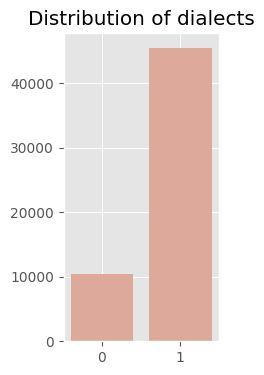

In [15]:
fig = plt.figure(figsize =(2, 4))
plt.bar(data['Label'].value_counts().index, data['Label'].value_counts(),color ='#DCA99A');
plt.title("Distribution of dialects");

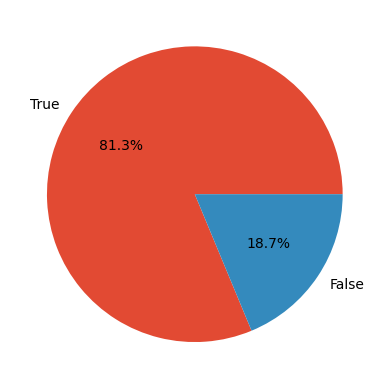

0.23043057145372897


In [16]:
label_count = data['Label'].value_counts()
labels = ['True', 'False']

plt.pie(label_count, labels=labels, autopct='%1.1f%%')

plt.show()

print(label_count[0] / label_count[1])

In [17]:
data['text lenght'] = data['text'].map(lambda i: len(i.split()))

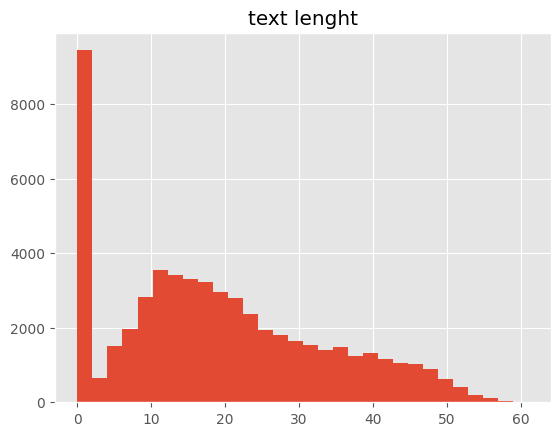

In [18]:
data[['text lenght']].hist(bins = 30)
plt.show()

In [19]:
data['text lenght'].max()

61

In [20]:
from sklearn.model_selection import train_test_split

# Assuming your original dataframe is called 'df'
train_val_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

In [21]:
train_df


,text,Label,text lenght
50957,اما محمد بن نايف واعفاءه كلنا الحمدلله سلما...,0,15
17621,التطبيعجريمه التطبيعخيانهالقرامطه و ال سلول ث...,1,22
14815,يحق لحضرتك ان تنتقضه لان الخسيس لا يمثل مصر في...,1,35
27430,ما هو الا كلب قذر يحاول تلميع وجوه اسياده من ...,1,17
45370,يا ضحيه يا ابن الضحيه اجهز علي كل ذءب بارض الع...,1,23
...,...,...,...
9739,ارحلياسيسيي يا مولانا اتق الله وبلاش موالاه ال...,1,23
28028,اذا انت رجل قل يخسي ال سلول ان اعبدهم واكون...,1,22
36635,عادي كم من فنان تغني بحكام ال سلول وغيرهم م...,1,12
33275,واخر من يتكلم عن الاجرام انتم يا ال سلول يا ا...,1,13


In [22]:
train_df['Label']

50957    0
17621    1
14815    1
27430    1
45370    1
        ..
9739     1
28028    1
36635    1
33275    1
40244    1
Name: Label, Length: 35772, dtype: int64

In [23]:
model = AutoModelForSequenceClassification.from_pretrained('UBC-NLP/MARBERTV2', num_labels=len(train_df['Label'].unique()))
tokenizer = BertTokenizerFast.from_pretrained('UBC-NLP/MARBERTV2')

Some weights of the model checkpoint at UBC-NLP/MARBERTV2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

In [24]:
train_encodings = tokenizer(train_df['text'].to_list(), truncation=True, padding=True, max_length=60)
val_encodings = tokenizer(val_df['text'].to_list(), truncation=True, padding=True, max_length=60)
test_encodings = tokenizer(test_df['text'].to_list(), truncation=True, padding=True, max_length=60)

In [25]:
train_labels = train_df['Label']
val_labels = val_df['Label']
test_labels = test_df['Label']

In [26]:
from torch.utils.data import Dataset, DataLoader

In [27]:
class DialectsDataset(Dataset):
  def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels.to_list()

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

  def __len__(self):
      return len(self.labels)

In [28]:
ds_train = DialectsDataset(train_encodings, train_labels)
ds_val =  DialectsDataset(val_encodings, val_labels)
ds_test =  DialectsDataset(test_encodings, test_labels)

In [29]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  acc = accuracy_score(labels, predictions)
  return {
      'accuracy': acc,
  }

In [37]:
training_args = TrainingArguments(
    output_dir='results',          
    num_train_epochs=2,              
    per_device_train_batch_size=64, 
    per_device_eval_batch_size=32,       
    evaluation_strategy = "epoch",        
    save_strategy = 'epoch',
    )

trainer = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=ds_train,
    eval_dataset=ds_val,                       
    compute_metrics=compute_metrics
)

In [38]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.074600,0.074861,0.977974
2,0.066000,0.072861,0.978980


TrainOutput(global_step=1118, training_loss=0.06921325344092517, metrics={'train_runtime': 731.636, 'train_samples_per_second': 97.786, 'train_steps_per_second': 1.528, 'total_flos': 2205939532579200.0, 'train_loss': 0.06921325344092517, 'epoch': 2.0})

In [39]:
preds = trainer.predict(ds_test)

In [40]:
y_pred = [np.argmax(i, axis=-1) for i  in preds.predictions]
y_test = ds_test.labels

In [41]:
accuracy_score(y_test, y_pred)

0.9782647584973166

In [42]:
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)

def interpret(explainer,text,TrueClass,name):
  word_attributions = explainer(text)
  explainer.visualize(name,true_class=TrueClass)
  return word_attributions

In [44]:
word_attributions = interpret(cls_explainer,"الامريكان كفار و يلعن ابو الرئيس السيسي",3,'exp')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_1 (1.00),LABEL_1,1.55,[CLS] الامريكان كفار و يلعن ابو الرييس السيسي [SEP]


In [46]:
word_attributions = interpret(cls_explainer,"انا بحب السيسي",3,'exp')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_1 (1.00),LABEL_1,0.96,[CLS] انا بحب السيسي [SEP]


In [47]:
word_attributions = interpret(cls_explainer,"انا اريد ان ادخل فيلم دراما",3,'exp')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_1 (0.67),LABEL_1,-0.88,[CLS] انا اريد ان ادخل فيلم دراما [SEP]
